In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
import os
root_path = 'gdrive/My Drive/EACL/'
os.chdir(root_path)

Mounted at /content/gdrive


In [ ]:
!pip install sentencepiece==0.1.94
!pip install transformers==4.0.1
!pip install demoji
!pip install tweet-preprocessor
# !pip install transformers[sentencepiece]

In [130]:
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn as nn
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, DataLoader, IterableDataset, ConcatDataset
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score 
from tqdm import tqdm
import demoji 
import random
demoji.download_codes() 
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})
RANDOM_SEED = 42
model_path = 'bert-base-multilingual-cased'
model_path = 'xlm-roberta-base'
# model_path = 'ai4bharat/indic-bert'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

... OK (Got response in 0.17 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [131]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)

In [132]:
texts = []

In [134]:
class Dataset():
    def __init__(self, train_data, val_data, test_data, model_path, batch_size = 32):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.model_path = model_path

        self.label_dict = {'Not_offensive': 0,
                            'Offensive_Targeted_Insult_Group': 4,
                            'Offensive_Targeted_Insult_Individual': 3,
                            'Offensive_Targeted_Insult_Other': 2,
                            'Offensive_Untargetede': 1,
                            'not-Kannada': 5}
        
# {'Not_offensive': 0,
#  'Offensive_Targeted_Insult_Group': 2,
#  'Offensive_Targeted_Insult_Individual': 4,
#  'Offensive_Targeted_Insult_Other': 3,
#  'Offensive_Untargetede': 5,
#  'not-Kannada': 1}
# {'Not_offensive': 0,
#  'Offensive_Targeted_Insult_Group': 3,
#  'Offensive_Targeted_Insult_Individual': 5,
#  'Offensive_Targeted_Insult_Other': 2,
#  'Offensive_Untargetede': 4,
#  'not-Tamil': 1}
        # self.label_dict = {'Not_offensive': 0,
        #                     'Offensive_Targeted_Insult_Group': 3,
        #                     'Offensive_Targeted_Insult_Individual': 5,
        #                     'Offensive_Targeted_Insult_Other': 2,
        #                     'Offensive_Untargetede': 4,
        #                     'not-Kannada': 1}
                                    
        self.count_dic = {}
        self.dict_label = {v:k for k,v in self.label_dict.items()}
        self.train_inputs, self.train_labels = self.process_data(self.train_data)
        self.val_inputs, self.val_labels = self.process_data(self.val_data)
        self.test_dataloader = self.process_data(self.test_data, test = True)
        self.train_dataloader = self.get_dataloader(self.train_inputs, self.train_labels)
        self.val_dataloader = self.get_dataloader(self.val_inputs, self. val_labels, train = False)

    def tokenize(self, sentences, padding = True, max_len = 256):
        tokenizer = AutoTokenizer.from_pretrained(self.model_path, use_fast=False)
        input_ids, attention_masks = [], []
        for sent in sentences:
            encoded_dict = tokenizer.encode_plus(sent,
                                                    add_special_tokens=True,
                                                    max_length=max_len, 
                                                    padding='max_length', 
                                                    return_attention_mask = True,
                                                    return_tensors = 'pt', 
                                                    truncation = True)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return {'input_ids': input_ids, 'attention_masks': attention_masks}
    
    def process_data(self, data, test = False):
        global texts
        sentences, labels = [], []
        texts = []
        print(len(data))
        for line in data:
            sentence = line.strip().split('\t')
            if not test: label = sentence.pop()
            # if label == 'not-Kannada': print(sentence)
            if test: texts.append(' '.join(sentence))
            # if label not in self.label_dict:
            #     self.label_dict[label] = len(self.label_dict)
            sentence = p.clean(' '.join(sentence)).replace('#','')
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            if not test:
                labels.append(self.label_dict[label])
                self.count_dic[labels[-1]] = self.count_dic.get(labels[-1], 0) + 1
        inputs = self.tokenize(sentences)

        if test:
            data = TensorDataset(inputs['input_ids'], inputs['attention_masks'])
            return DataLoader(data, sampler=SequentialSampler(data), batch_size=self.batch_size*2)
        return inputs, torch.Tensor(labels)
    
    def get_dataloader(self, inputs, labels, train = True):
        data = TensorDataset(inputs['input_ids'], inputs['attention_masks'], labels)
        if train:
            sampler = RandomSampler(data)
        else:
            sampler = SequentialSampler(data)
        return DataLoader(data, sampler=sampler, batch_size=self.batch_size)

In [135]:
# Save and Load Functions
def save_metrics(save_path, epochs, model, optimizer, F1):

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'epochs': epochs+1,
                  'F1': F1}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, model, optimizer):
    try: 
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict['model_state_dict'])
        optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    except: 
        state_dict = {}

    print(f'Model loaded from <== {load_path}')
    
    return state_dict.get('epochs', 0), state_dict.get('F1', 0)

def load_metrics_new(load_path, model):
    try: 
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict['model_state_dict'])
    except: 
        state_dict = {}

    print(f'Model loaded from <== {load_path}')
    
    return state_dict.get('epochs', 0), state_dict.get('F1', 0)

In [136]:
class Transform(torch.nn.Module):
    def __init__(self, D_in, num_labels, model_path):
        super(Transform, self).__init__()
        self.embeddings = AutoModel.from_pretrained(model_path)
        self.dropout = nn.Dropout(0.3)
        self.final = nn.Linear(D_in*2, num_labels, bias = True)

    def forward(self, input_ids, mask):
        outputs = self.embeddings(input_ids, mask)
        out = outputs.last_hidden_state
        mean_pooling = torch.mean(out, 1)
        max_pooling, _ = torch.max(out, 1)

        embed = torch.cat((mean_pooling, max_pooling), 1)
        y_pred = self.final(self.dropout(embed))
        return y_pred

In [137]:
class Transform_old(torch.nn.Module):
    def __init__(self, D_in, num_labels, model_path):
        super(Transform_old, self).__init__()
        self.embeddings = AutoModel.from_pretrained(model_path)
        # self.dropout = nn.Dropout(0.3)
        self.final = nn.Linear(D_in, num_labels, bias = True)

    def forward(self, input_ids, mask):
        outputs = self.embeddings(input_ids, mask)
        out = outputs.pooler_output
        # mean_pooling = torch.mean(out, 1)
        # max_pooling, _ = torch.max(out, 1)

        # embed = torch.cat((mean_pooling, max_pooling), 1)
        y_pred = self.final((out))
        return y_pred

In [138]:

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
 
def get_predicted(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat

def infer(test_dataloader, model):
    model.eval()
    y_logits, y_test = np.array([]), np.array([])

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)
        soft = nn.Softmax(dim=1)
        ypred = soft(ypred).cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        if len(y_logits) == 0: y_logits = np.copy(ypred)
        else: y_logits = np.concatenate((y_logits, ypred), axis = 0)
        y_test = np.hstack((y_test, label_ids))

    # weighted_f1 = f1_score(y_test, y_preds, average='weighted')
    return y_logits, y_test

def infer_test(test_dataloader, model):
    model.eval()
    y_logits = np.array([])

    for batch in test_dataloader:
        b_input_ids, b_input_mask = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)
        soft = nn.Softmax(dim=1)
        ypred = soft(ypred).cpu().numpy()
        if len(y_logits) == 0: y_logits = np.copy(ypred)
        else: y_logits = np.concatenate((y_logits, ypred), axis = 0)

    # weighted_f1 = f1_score(y_test, y_preds, average='weighted')
    return y_logits

def evaluate(test_dataloader, model_lang, model_disc):
    model_lang.eval()
    model_disc.eval()
    y_preds_lang, y_preds_disc, y_test = np.array([]), np.array([]), np.array([])

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            ypred_lang = model_lang(b_input_ids, b_input_mask)
            ypred_disc = model_disc(b_input_ids, b_input_mask)
        ypred_lang = ypred_lang.cpu().numpy()
        ypred_disc = ypred_disc.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds_lang = np.hstack((y_preds_lang, get_predicted(ypred_lang)))
        y_preds_disc = np.hstack((y_preds_disc, get_predicted(ypred_disc)))
        y_test = np.hstack((y_test, label_ids))

    y_preds = []
    for i in range(len(y_preds_lang)):
        lang = int(y_preds_lang[i])
        if lang:
            y_preds.append(5)
        else:
            y_preds.append(int(y_preds_disc[i]))
    y_preds = np.array(y_preds)
    weighted_f1 = f1_score(y_test, y_preds, average='weighted')
    return weighted_f1, y_preds, y_test

In [139]:
model_paths = ['bert-base-multilingual-cased', 'xlm-roberta-base', 'ai4bharat/indic-bert']
with open('Dataset/kannada_offensive_train.csv', 'r') as f:
    train_data = f.readlines()
with open('Dataset/kannada_offensive_dev.csv', 'r') as f:
    val_data = f.readlines()
with open('Dataset/kannada_offensive_test.csv', 'r') as f:
    test_data = f.readlines()

In [140]:
data = Dataset(train_data, val_data, test_data, model_path = model_paths[0])
model = Transform(768, 6, model_paths[0]).to(device)
print(load_metrics_new('olid_mbert_kan.pt', model))
mbert_logits, ytest = infer(data.val_dataloader, model)
mbert_logits_test = infer_test(data.test_dataloader, model)
logits = {}
logits['val'] = mbert_logits
logits['test'] = mbert_logits_test
with open('mbert_kan_preds.pkl', 'wb') as f:
    pickle.dump(logits, f)

6217
777
778
Model loaded from <== olid_mbert_kan.pt
(6, 0.6979066927289537)


In [141]:
data = Dataset(train_data, val_data, test_data, model_path = model_paths[1])
model = Transform(768, 6, model_paths[1]).to(device)
print(load_metrics_new('olid_xlmr_kannada.pt', model))
xlmr_logits, ytest = infer(data.val_dataloader, model)
xlmr_logits_test = infer_test(data.test_dataloader, model)
logits = {}
logits['val'] = xlmr_logits
logits['test'] = xlmr_logits_test
with open('xlmr_kan_preds.pkl', 'wb') as f:
    pickle.dump(logits, f)

6217
777
778
Model loaded from <== olid_xlmr_kannada.pt
(4, 0.7173666600379546)


In [ ]:
data = Dataset(train_data, val_data, model_path = model_paths[2])
model = Transform(768, 6, model_paths[2]).to(device)
print(load_metrics_new('olid_indic_tamil.pt', model))
indic_logits, ytest = infer(data.val_dataloader, model)

35139
4388
Model loaded from <== olid_indic_tamil.pt
(2, 0.7491062076943162)


In [121]:
pred = get_predicted(np.maximum(np.maximum(np.maximum(xlmr_logits, mbert_logits), ulm_logits_val), xlmr_logits))
f1 = f1_score(ytest, pred, average='weighted')
print(f1)

0.969800143469903


In [53]:
from sklearn.metrics import accuracy_score

In [147]:
pred = get_predicted(ulm_logits_test+xlmr_logits_test+mbert_logits_test)
# f1 = f1_score(ytest, pred, average='weighted')
# f1 = accuracy_score(ytest, pred)
print(f1)

0.7322034390034591


In [146]:
pred = get_predicted(ulm_logits_val+xlmr_logits+mbert_logits)
f1 = f1_score(ytest, pred, average='weighted')
# f1 = accuracy_score(ytest, pred)
print(f1)

0.7322034390034591


In [94]:
pred.shape

torch.Size([4392])

In [ ]:
pred = []
xpred = get_predicted(xlmr_logits)
mpred = get_predicted(mbert_logits)
ipred = get_predicted(ulm_logtits)
for x,m,i in zip(xpred, mpred, ipred):
    if x==m or x==i: pred.append(x)
    elif m==i: pred.append(m)
    else: pred.append(x)
f1 = f1_score(ytest, pred, average='weighted')
print(f1)

0.7316819662155792


In [76]:
xlmr_logits_test

array([[0.43115187, 0.12660089, 0.10991456, 0.16274162, 0.0895111 ,
        0.08007997],
       [0.43115187, 0.12660089, 0.10991456, 0.16274162, 0.0895111 ,
        0.08007997],
       [0.43115187, 0.12660089, 0.10991456, 0.16274162, 0.0895111 ,
        0.08007997],
       ...,
       [0.43115178, 0.1266009 , 0.1099146 , 0.16274166, 0.08951113,
        0.08007994],
       [0.43115178, 0.1266009 , 0.1099146 , 0.16274166, 0.08951113,
        0.08007994],
       [0.43115178, 0.1266009 , 0.1099146 , 0.16274166, 0.08951113,
        0.08007994]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(ytest, pred)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [39]:
import pickle
with open('tam_ulmfit_preds.pkl', 'rb') as f:
    ulm_logits = pickle.load(f)
print(ulm_logits)
ulm_logits_tam = torch.index_select(ulm_logits['test'], 1, torch.LongTensor([0,4,2,5,3,1]))

{'val': tensor([[9.4630e-01, 2.5260e-02, 2.2303e-03, 4.5569e-03, 1.7176e-02, 4.4743e-03],
        [9.9871e-01, 1.1815e-04, 7.0968e-05, 1.9295e-04, 5.7516e-04, 3.2838e-04],
        [1.1492e-01, 8.4584e-01, 3.3452e-03, 5.3570e-03, 1.2424e-02, 1.8113e-02],
        ...,
        [1.2351e-01, 3.7066e-03, 3.0324e-02, 3.9621e-01, 3.8728e-01, 5.8961e-02],
        [9.8717e-01, 4.8754e-03, 6.6320e-04, 2.3366e-03, 7.6715e-04, 4.1830e-03],
        [9.8976e-01, 2.5471e-04, 1.0145e-03, 1.1184e-03, 5.9199e-03, 1.9294e-03]]), 'test': tensor([[9.7739e-01, 1.2637e-05, 4.7476e-04, 1.6637e-03, 1.8689e-02, 1.7674e-03],
        [7.1744e-01, 1.3114e-04, 1.9899e-02, 4.1196e-02, 2.0459e-01, 1.6744e-02],
        [1.8518e-01, 8.1388e-01, 2.0480e-04, 1.8708e-04, 3.3984e-04, 2.0586e-04],
        ...,
        [3.7247e-01, 1.4980e-03, 3.5686e-02, 2.7768e-01, 2.8655e-01, 2.6119e-02],
        [7.2332e-01, 8.0857e-03, 1.4075e-02, 1.0035e-01, 2.9068e-02, 1.2511e-01],
        [7.6852e-02, 1.3278e-02, 5.5149e-02, 3.3028e-0

In [119]:
import pickle
with open('mal_ulmfit_preds.pkl', 'rb') as f:
    ulm_logits = pickle.load(f)
print(ulm_logits)
ulm_logits_val = torch.index_select(ulm_logits['val'], 1, torch.LongTensor([0,4,2,1,3]))
ulm_logits_test = torch.index_select(ulm_logits['test'], 1, torch.LongTensor([0,4,2,1,3]))

{'val': tensor([[9.9991e-01, 8.2056e-05, 7.4294e-06, 2.2854e-07, 1.0521e-06],
        [1.0000e+00, 7.2056e-07, 5.7720e-08, 1.1636e-07, 1.9978e-07],
        [9.9999e-01, 4.7877e-06, 2.7178e-07, 3.8088e-08, 5.9020e-07],
        ...,
        [9.6041e-01, 4.4667e-03, 1.3528e-06, 4.2075e-03, 3.0917e-02],
        [9.9804e-01, 2.3449e-04, 1.0931e-03, 2.5722e-04, 3.7776e-04],
        [9.9907e-01, 5.2230e-06, 9.1669e-04, 1.1944e-06, 4.6608e-06]]), 'test': tensor([[9.9996e-01, 3.5191e-05, 1.4365e-07, 1.0257e-07, 2.9254e-06],
        [9.9949e-01, 6.9551e-05, 6.0725e-06, 2.8586e-05, 4.0866e-04],
        [9.9737e-01, 1.9562e-03, 4.6076e-04, 1.0261e-04, 1.1077e-04],
        ...,
        [9.9906e-01, 5.2406e-05, 1.2549e-04, 4.7273e-04, 2.9276e-04],
        [9.9998e-01, 7.3564e-06, 7.8305e-08, 5.1346e-06, 6.8880e-06],
        [9.9940e-01, 4.4977e-04, 4.8819e-06, 6.2034e-05, 8.3402e-05]])}


In [142]:
import pickle
with open('kan_ulmfit_preds.pkl', 'rb') as f:
    ulm_logits = pickle.load(f)
ulm_logits_val = torch.index_select(ulm_logits['val'], 1, torch.LongTensor([0,5,3,4,2,1]))
ulm_logits_test = torch.index_select(ulm_logits['test'], 1, torch.LongTensor([0,5,3,4,2,1]))

In [58]:
type(pred)

torch.Tensor

In [148]:
labels = [data.dict_label[x] for x in np.array(pred)]
len(texts), len(labels)

(778, 778)

In [149]:
df = pd.DataFrame()
df['id'] = range(1, len(pred)+1)
df['text'] = texts
df['label'] = labels
df.to_csv('indicnlp@kgp_kannada.csv',sep=',', index = False)

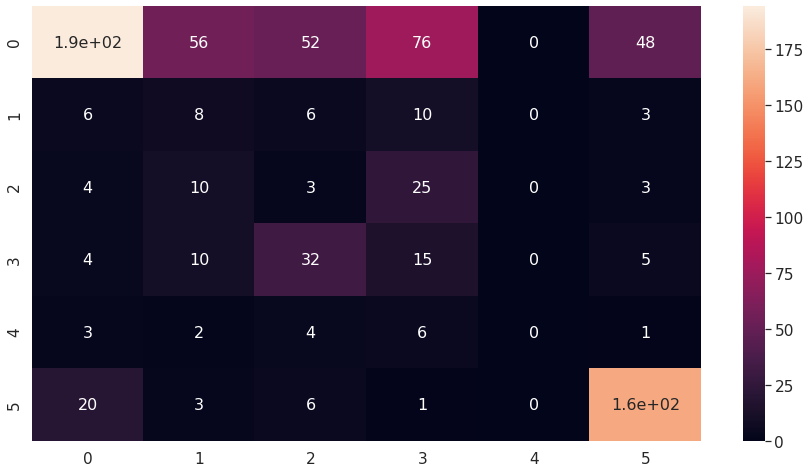

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()